# WhatPulse Keypress Counter

By Kenneth Burchfiel

Released under the MIT license

(I am not affiliated with WhatPulse (https://whatpulse.org) but highly recommend checking out the program, which I've used since September 2008. You can find my online WhatPulse page here: https://whatpulse.org/KBurchfiel)

This program reads Whatpulse keypress data (stored in local SQLite databases); combines that data into a single Pandas DataFrame; and then performs analyses on that data.

More documentation/explanation of the code will be provided in the future.

In [1]:
import time
start_time = time.time() # Allows the program's runtime to be measured
import pandas as pd
import sqlalchemy
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from scipy.stats import percentileofscore
import plotly.express as px
import kaleido
from IPython.display import Image

## Importing Whatpulse data

The first step will be to import data from my local Whatpulse database, along with a copy of the Whatpulse database stored on my old laptop.

In [2]:
database_paths_list = [r'C:\Users\kburc\AppData\Local\whatpulse\whatpulse.db', r'C:\Users\kburc\D1V1\Documents\whatpulse_database_backups\a13r2_whatpulse.db'] 
# Note that the first path is to my computer's active database, and that the second path is to a copy of the database stored on my old computer. This approach allows me to include keypress stats that go beyond those stored on my computer.

The following function analyzes each database's keypresses table.

In [3]:
def generate_daily_keypress_totals(database_path):
    file_name = database_path.split('\\')[-1]
    sqlalchemy_sqlite_engine = sqlalchemy.create_engine('sqlite:///'+database_path) # Based on https://docs.sqlalchemy.org/en/13/dialects/sqlite.html#connect-strings
    sqlalchemy_connection = sqlalchemy_sqlite_engine.connect()
    df_keypresses = pd.read_sql("select * from keypresses", con = sqlalchemy_sqlite_engine)
    df_keypresses.drop('hour',axis=1,inplace=True) # I'm only interested in 
    # daily keypresses for the purposes of this program. (In the future, I may
    # examine keypresses by hour as well.)
    df_daily_keypresses = df_keypresses.groupby('day').sum()
    if '0000-00-00' in df_daily_keypresses.index:
        df_daily_keypresses.drop('0000-00-00',inplace=True)
    df_daily_keypresses.rename(columns={'count':'keypresses'},inplace=True)    
    df_daily_keypresses.sort_values('day',inplace=True)
    df_daily_keypresses['source'] = database_path.split('\\')[-1]
    print("\nNow analyzing", database_path.split('\\')[-1]+":")
    print("Total keypresses so far with this computer:",sum(df_daily_keypresses['keypresses']))
    print("Maximum keypresses in one day with this computer:",max(df_daily_keypresses['keypresses']))
    print("Average daily keypresses (at least for days with 1 or more keypresses):",np.mean(df_daily_keypresses['keypresses']))
    # plt.plot(df_daily_keypresses['keypresses'])
    return df_daily_keypresses

In [4]:
def generate_hourly_keypress_totals(database_path):
    file_name = database_path.split('\\')[-1]
    sqlalchemy_sqlite_engine = sqlalchemy.create_engine('sqlite:///'+database_path) # Based on https://docs.sqlalchemy.org/en/13/dialects/sqlite.html#connect-strings
    sqlalchemy_connection = sqlalchemy_sqlite_engine.connect()
    df_keypresses = pd.read_sql("select * from keypresses", con = sqlalchemy_sqlite_engine)
    df_keypresses = df_keypresses.query("day != '0000-00-00'").copy() # Removes 
    # any rows that have a date of 0000-00-00
    return df_keypresses

In [5]:
keypress_databases_list = []

for path in database_paths_list:
    keypress_databases_list.append(generate_daily_keypress_totals(path))

df_combined_daily_keypresses = pd.concat([keypress_databases_list[i] for i in range(len(keypress_databases_list))])
df_combined_daily_keypresses.sort_index(inplace=True)
df_combined_daily_keypresses = df_combined_daily_keypresses.groupby('day').sum() # This gets rid of the 'source' column, but that's OK, since this line is necessary to adjust for days where multiple computers were used.
df_combined_daily_keypresses.index = pd.to_datetime(df_combined_daily_keypresses.index)
print(len(df_combined_daily_keypresses))
df_combined_daily_keypresses



Now analyzing whatpulse.db:
Total keypresses so far with this computer: 12201955
Maximum keypresses in one day with this computer: 90447
Average daily keypresses (at least for days with 1 or more keypresses): 24600.71572580645

Now analyzing a13r2_whatpulse.db:
Total keypresses so far with this computer: 8493955
Maximum keypresses in one day with this computer: 77753
Average daily keypresses (at least for days with 1 or more keypresses): 30775.19927536232
766


,keypresses
day,
2020-09-21,19081
2020-09-22,32771
2020-09-23,32065
2020-09-24,34698
2020-09-25,47038
...,...
2022-12-02,28416
2022-12-03,2852
2022-12-04,22045


The following code block fills in the DataFrame with missing dates (e.g. dates in which I did not have any keypresses).

In [6]:
first_date = df_combined_daily_keypresses.index[0]
last_date = df_combined_daily_keypresses.index[-1]
full_date_range = pd.date_range(start=first_date, end = last_date) # https://pandas.pydata.org/docs/reference/api/pandas.date_range.html
df_combined_daily_keypresses = df_combined_daily_keypresses.reindex(full_date_range, fill_value=0) # See https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reindex.html
df_combined_daily_keypresses.index.name = 'Date'
df_combined_daily_keypresses.reset_index(inplace=True) 

In [7]:
df_combined_daily_keypresses['7_day_ma'] = df_combined_daily_keypresses['keypresses'].rolling(7).mean()
df_combined_daily_keypresses['28_day_ma'] = df_combined_daily_keypresses['keypresses'].rolling(28).mean() 
# I switched from a 30-day MA to a 28-day MA because my average keypresses vary significantly by weekday, meaning
# that a 30-day average would be skewed by the number of Saturdays and Sundays present in the data.
df_combined_daily_keypresses['365_day_ma'] = df_combined_daily_keypresses['keypresses'].rolling(365).mean()
print(len(df_combined_daily_keypresses))
df_combined_daily_keypresses['percentile'] = 100*df_combined_daily_keypresses['keypresses'].rank(pct=True)
df_combined_daily_keypresses['rank'] = df_combined_daily_keypresses['keypresses'].rank(ascending = False)
df_combined_daily_keypresses

807


,Date,keypresses,7_day_ma,28_day_ma,365_day_ma,percentile,rank
0,2020-09-21,19081,NaN,NaN,NaN,38.909542,494.0
1,2020-09-22,32771,NaN,NaN,NaN,65.675341,278.0
2,2020-09-23,32065,NaN,NaN,NaN,64.312268,289.0
3,2020-09-24,34698,NaN,NaN,NaN,68.215613,257.5
4,2020-09-25,47038,NaN,NaN,NaN,86.741016,108.0
...,...,...,...,...,...,...,...
802,2022-12-02,28416,33176.000000,24393.464286,20240.350685,58.240397,338.0
803,2022-12-03,2852,26565.285714,23985.178571,20208.687671,14.250310,693.0
804,2022-12-04,22045,26798.428571,24571.785714,20260.328767,44.237918,451.0
805,2022-12-05,90447,34728.714286,26518.821429,20476.994521,100.000000,1.0


Adding in weekdays:

In [8]:
df_weekday_mapping = pd.DataFrame({"Number":[0, 1, 2, 3, 4, 5, 6], "Weekday":["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]})
# Weekday numbers in Python begin with 0 for Monday and end with 6 for Sunday. See https://docs.python.org/3/library/datetime.html#datetime.date.weekday
df_weekday_mapping

,Number,Weekday
0,0,Monday
1,1,Tuesday
2,2,Wednesday
3,3,Thursday
4,4,Friday
5,5,Saturday
6,6,Sunday


In [9]:
df_combined_daily_keypresses['weekday_num'] = df_combined_daily_keypresses['Date'].dt.weekday.copy()
df_combined_daily_keypresses

,Date,keypresses,7_day_ma,28_day_ma,365_day_ma,percentile,rank,weekday_num
0,2020-09-21,19081,NaN,NaN,NaN,38.909542,494.0,0
1,2020-09-22,32771,NaN,NaN,NaN,65.675341,278.0,1
2,2020-09-23,32065,NaN,NaN,NaN,64.312268,289.0,2
3,2020-09-24,34698,NaN,NaN,NaN,68.215613,257.5,3
4,2020-09-25,47038,NaN,NaN,NaN,86.741016,108.0,4
...,...,...,...,...,...,...,...,...
802,2022-12-02,28416,33176.000000,24393.464286,20240.350685,58.240397,338.0,4
803,2022-12-03,2852,26565.285714,23985.178571,20208.687671,14.250310,693.0,5
804,2022-12-04,22045,26798.428571,24571.785714,20260.328767,44.237918,451.0,6
805,2022-12-05,90447,34728.714286,26518.821429,20476.994521,100.000000,1.0,0


In [10]:
df_combined_daily_keypresses = df_combined_daily_keypresses.merge(df_weekday_mapping, left_on = 'weekday_num', right_on = 'Number', how = 'left')
# If the 'how' field is left blank, the resulting DataFrame will be sorted by weekday instead of by date.
# Sorting by the Date column is necessary here since the merge operation sorted the data by 
df_combined_daily_keypresses.drop(['weekday_num', 'Number'], axis = 1, inplace = True)
df_combined_daily_keypresses

,Date,keypresses,7_day_ma,28_day_ma,365_day_ma,percentile,rank,Weekday
0,2020-09-21,19081,NaN,NaN,NaN,38.909542,494.0,Monday
1,2020-09-22,32771,NaN,NaN,NaN,65.675341,278.0,Tuesday
2,2020-09-23,32065,NaN,NaN,NaN,64.312268,289.0,Wednesday
3,2020-09-24,34698,NaN,NaN,NaN,68.215613,257.5,Thursday
4,2020-09-25,47038,NaN,NaN,NaN,86.741016,108.0,Friday
...,...,...,...,...,...,...,...,...
802,2022-12-02,28416,33176.000000,24393.464286,20240.350685,58.240397,338.0,Friday
803,2022-12-03,2852,26565.285714,23985.178571,20208.687671,14.250310,693.0,Saturday
804,2022-12-04,22045,26798.428571,24571.785714,20260.328767,44.237918,451.0,Sunday
805,2022-12-05,90447,34728.714286,26518.821429,20476.994521,100.000000,1.0,Monday


Summary daily keypress data statistics:

In [11]:
df_combined_daily_keypresses['keypresses'].describe()

count      807.000000
mean     25645.489467
std      18133.468484
min          0.000000
25%       9935.500000
50%      25075.000000
75%      38382.000000
max      90447.000000
Name: keypresses, dtype: float64

In [12]:
df_combined_daily_keypresses.tail(10) # Last 10 days of data

,Date,keypresses,7_day_ma,28_day_ma,365_day_ma,percentile,rank,Weekday
797,2022-11-27,20413,20960.571429,24561.678571,20328.717808,41.387856,474.0,Sunday
798,2022-11-28,34935,23713.857143,24685.500000,20311.594521,68.773234,253.0,Monday
799,2022-11-29,20613,21162.571429,24063.285714,20261.772603,41.759603,471.0,Tuesday
800,2022-11-30,44702,25320.285714,24778.892857,20283.361644,84.014870,130.0,Wednesday
801,2022-12-01,34026,30173.857143,24523.821429,20294.517808,66.914498,268.0,Thursday
802,2022-12-02,28416,33176.000000,24393.464286,20240.350685,58.240397,338.0,Friday
803,2022-12-03,2852,26565.285714,23985.178571,20208.687671,14.250310,693.0,Saturday
804,2022-12-04,22045,26798.428571,24571.785714,20260.328767,44.237918,451.0,Sunday
805,2022-12-05,90447,34728.714286,26518.821429,20476.994521,100.000000,1.0,Monday
806,2022-12-06,2642,32161.428571,25299.214286,20324.635616,13.878563,696.0,Tuesday


## My top 50 keypress totals:

In [13]:
df_max_keypresses = df_combined_daily_keypresses.sort_values('keypresses', ascending = False).reset_index(drop=True)
df_max_keypresses.insert(0, 'Rank', df_max_keypresses.index+1)
keypress_difference_list = [df_max_keypresses.iloc[i]['keypresses'] - df_max_keypresses.iloc[i+1]['keypresses'] for i in range(len(df_max_keypresses) -1 )]
# This list comprehension calculates the difference between each row and the row below it. This isn't possible for the final row,
# so we'll instead append a np.Nan to it.)
keypress_difference_list.append(np.NaN)
df_max_keypresses['difference_from_lower_rank'] = keypress_difference_list
df_max_keypresses.head(50)

,Rank,Date,keypresses,7_day_ma,28_day_ma,365_day_ma,percentile,rank,Weekday,difference_from_lower_rank
0,1,2022-12-05,90447,34728.714286,26518.821429,20476.994521,100.000000,1.0,Monday,12694.0
1,2,2021-02-22,77753,47983.000000,41390.857143,NaN,99.876084,2.0,Monday,1440.0
2,3,2020-11-23,76313,50377.571429,39924.107143,NaN,99.752169,3.0,Monday,869.0
3,4,2020-11-19,75444,47285.571429,37945.892857,NaN,99.628253,4.0,Thursday,1656.0
4,5,2021-11-09,73788,37843.285714,30462.071429,29584.802740,99.504337,5.0,Tuesday,878.0
5,6,2022-05-03,72910,30511.428571,28489.285714,24401.624658,99.380421,6.0,Tuesday,2319.0
6,7,2021-02-08,70591,30177.428571,34437.357143,NaN,99.256506,7.0,Monday,2278.0
7,8,2021-04-06,68313,40455.857143,40719.178571,NaN,99.132590,8.0,Tuesday,383.0
8,9,2021-02-15,67930,46174.571429,40268.535714,NaN,99.008674,9.0,Monday,397.0
9,10,2020-11-30,67533,20747.428571,36843.714286,NaN,98.884758,10.0,Monday,28.0


<BarContainer object of 50 artists>

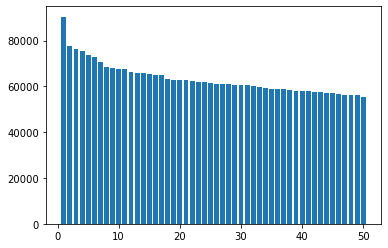

In [14]:
plt.bar(x = df_max_keypresses.head(50)['Rank'], height= df_max_keypresses.head(50)['keypresses'])

In [15]:
df_combined_daily_keypresses.describe()

,keypresses,7_day_ma,28_day_ma,365_day_ma,percentile,rank
count,807.000000,801.000000,780.000000,443.000000,807.000000,807.000000
mean,25645.489467,25606.799715,25437.561859,24924.934809,50.061958,404.000000
std,18133.468484,10440.633651,7740.300537,3080.349819,28.883209,233.087494
min,0.000000,0.000000,8775.535714,20131.378082,2.726146,1.000000
25%,9935.500000,18352.714286,20007.848214,22939.410959,25.092937,202.500000
50%,25075.000000,26221.142857,24857.142857,24020.430137,50.061958,404.000000
75%,38382.000000,33069.000000,31064.285714,27878.569863,75.030979,605.500000
max,90447.000000,50377.571429,41579.714286,30033.476712,100.000000,786.000000


## Keypress percentiles:

In [16]:
df_combined_daily_keypresses['keypresses'].describe(percentiles=np.linspace(0.9,1,11))

count      807.000000
mean     25645.489467
std      18133.468484
min          0.000000
50%      25075.000000
90%      50068.400000
91%      51242.960000
92%      53080.640000
93%      54586.600000
94%      56017.920000
95%      57756.800000
96%      59679.720000
97%      61394.340000
98%      64666.120000
99%      67906.180000
100%     90447.000000
max      90447.000000
Name: keypresses, dtype: float64

Finding the percentile corresponding to a day with only a single keypress:

In [17]:
percentileofscore(df_combined_daily_keypresses['keypresses'], 1)

5.452292441140025

## Full percentile list (at 5% increments):

In [18]:
df_percentiles = df_combined_daily_keypresses['keypresses'].describe(
percentiles=np.linspace(0,1,21))[4:-1].reset_index().sort_values(
    'keypresses', ascending = False).reset_index(drop=True).rename(columns={'index':'percentile'})
# The first 3 rows and final row provide descriptive statistics that aren't 
# necessary to include within this DataFrame, so we can get rid of them
# by adding [4:-1] to the end of this line.
# Calling reset_index() twice appears inefficient, but it makes it easier
# to sort by a particular value (in this case, keypresses).
keypress_difference_list = [df_percentiles.iloc[i, 1] - df_percentiles.iloc[i+1, 1] for i in range(len(df_percentiles) -1 )]
# This list comprehension calculates the difference between each row and the row below it. This isn't possible for the final row,
# so we'll instead append a np.Nan to it.)
keypress_difference_list.append(np.NaN)
df_percentiles['difference_from_lower_percentile'] = keypress_difference_list
df_percentiles

,percentile,keypresses,difference_from_lower_percentile
0,100%,90447.0,32690.2
1,95%,57756.8,7688.4
2,90%,50068.4,4626.7
3,85%,45441.7,3803.7
4,80%,41638.0,3256.0
5,75%,38382.0,2809.0
6,70%,35573.0,3381.8
7,65%,32191.2,2486.0
8,60%,29705.2,2793.3
9,55%,26911.9,1836.9


<BarContainer object of 21 artists>

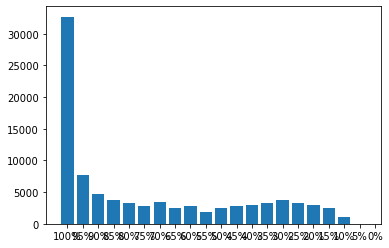

In [19]:
plt.bar(df_percentiles['percentile'], df_percentiles['difference_from_lower_percentile'])

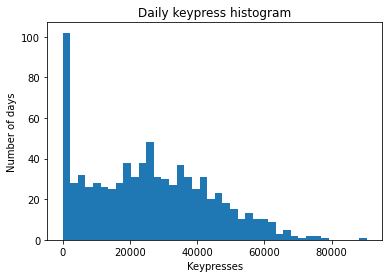

In [20]:
plt.hist(df_combined_daily_keypresses['keypresses'], bins = 40)
plt.xlabel('Keypresses')
plt.ylabel('Number of days')
plt.title('Daily keypress histogram')
plt.savefig('graphs\\keypress_histogram.png')

In [21]:
df_weekday_pivot = df_combined_daily_keypresses.pivot_table(index = 'Weekday', values = 'keypresses', aggfunc = 'mean').sort_values('keypresses', ascending = False).reset_index()
df_weekday_pivot

,Weekday,keypresses
0,Tuesday,33369.068966
1,Monday,33278.672414
2,Thursday,31569.069565
3,Wednesday,30419.495652
4,Friday,24309.652174
5,Saturday,14314.582609
6,Sunday,12124.347826


In [22]:
# The following line makes the Weekday column categorical so that it can be 
# sorted in a custom order (which I specify in the 'categories' parameter). 
# See https://pandas.pydata.org/docs/user_guide/categorical.html
df_weekday_pivot['Weekday'] = pd.Categorical(df_weekday_pivot['Weekday'], 
categories = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 
'Thursday', 'Friday', 'Saturday'], ordered = True)

In [23]:
df_weekday_pivot.sort_values('Weekday', inplace = True)
df_weekday_pivot

,Weekday,keypresses
6,Sunday,12124.347826
1,Monday,33278.672414
0,Tuesday,33369.068966
3,Wednesday,30419.495652
2,Thursday,31569.069565
4,Friday,24309.652174
5,Saturday,14314.582609


Graphing my average keypresses per weekday:

In [24]:
df_weekday_pivot

,Weekday,keypresses
6,Sunday,12124.347826
1,Monday,33278.672414
0,Tuesday,33369.068966
3,Wednesday,30419.495652
2,Thursday,31569.069565
4,Friday,24309.652174
5,Saturday,14314.582609


The following cell creates a series of colors that will be used as the bar labels for each weekday. Weekdays with more keypresses will be bluer, and weekdays with fewer keypresses will be grayer.

In [25]:
max_weekday_keypresses = max(df_weekday_pivot['keypresses'])
min_weekday_keypresses = min(df_weekday_pivot['keypresses'])
# The following line designates the colors as (r, g, b) tuples. r and g are always set to 0.5. b will be 0.5 on the day with the fewest keypresses and 1 on the day with the most keypresses.
bar_color_list = [(0.5, 0.5, 0.5 + 0.5*(keypress_value - min_weekday_keypresses)/(max_weekday_keypresses - min_weekday_keypresses)) for keypress_value in df_weekday_pivot['keypresses']]
bar_color_list

[(0.5, 0.5, 0.5),
 (0.5, 0.5, 0.9978724938037347),
 (0.5, 0.5, 1.0),
 (0.5, 0.5, 0.9305810301301412),
 (0.5, 0.5, 0.9576365491341037),
 (0.5, 0.5, 0.7867842855609462),
 (0.5, 0.5, 0.551547741395005)]

## Creating a chart of weekly average keypresses:

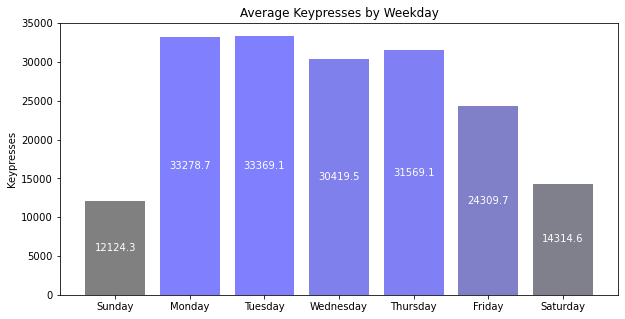

In [26]:
fig, ax = plt.subplots(figsize = [10, 5])
fig.set_facecolor('white')
bc = ax.bar(x = df_weekday_pivot['Weekday'], height = df_weekday_pivot['keypresses'], color = bar_color_list) # bc stands for 'bar container'
ax.bar_label(bc, label_type = 'center', color = 'white') 
plt.title("Average Keypresses by Weekday")
plt.ylabel("Keypresses")
# See https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html
plt.savefig('graphs\\average_keypresses_by_weekday.png', dpi=400)

In [27]:
print("Total keypresess since", str(df_combined_daily_keypresses.iloc[0]['Date'])+":",'{:,}'.format(sum(df_combined_daily_keypresses['keypresses'])))

Total keypresess since 2020-09-21 00:00:00: 20,695,910


In [28]:
df_combined_daily_keypresses.tail(50) # Last 50 days

,Date,keypresses,7_day_ma,28_day_ma,365_day_ma,percentile,rank,Weekday
757,2022-10-18,31145,19802.857143,18053.357143,20525.668493,62.205700,306.0,Tuesday
758,2022-10-19,27083,19973.428571,18892.428571,20456.791781,55.514250,360.0,Wednesday
759,2022-10-20,21121,14717.285714,19612.571429,20449.331507,42.750929,463.0,Thursday
760,2022-10-21,34606,18232.285714,20410.785714,20431.328767,68.029740,259.0,Friday
761,2022-10-22,16922,20429.142857,20633.071429,20413.673973,35.315985,523.0,Saturday
762,2022-10-23,12601,22229.285714,20244.000000,20422.243836,28.500620,578.0,Sunday
763,2022-10-24,31296,24967.714286,20615.464286,20507.986301,62.577447,303.0,Monday
764,2022-10-25,36769,25771.142857,20734.607143,20458.153425,72.242875,225.0,Tuesday
765,2022-10-26,26905,25745.714286,20627.357143,20359.476712,54.956629,364.5,Wednesday
766,2022-10-27,43233,28904.571429,22165.571429,20348.608219,82.527881,142.0,Thursday


# (See above for recent keypress stats)

In [29]:
days_with_data = len(df_combined_daily_keypresses)
#  The following column cell shows the ranks immediately above the ranks for the most recent day.
keypresses_today = df_combined_daily_keypresses.iloc[-1]['keypresses']
percentile_today = df_combined_daily_keypresses.iloc[-1]['percentile']
rank_today = df_combined_daily_keypresses.iloc[-1]['rank']
print("Ranks are out of", days_with_data, "days.")
print(f"Today's keypresses: {keypresses_today}")
print(f"Your keypress totals 7, 28, and 365 days ago were \
{df_combined_daily_keypresses.iloc[-8]['keypresses']}, \
{df_combined_daily_keypresses.iloc[-29]['keypresses']}, \
and {df_combined_daily_keypresses.iloc[-366]['keypresses']}, respectively.")
# If your keypresses today are higher than these values, the moving averages
# associated with those values will increase.
print(f"Today's percentile: {percentile_today}")
print(f"Today's rank: {rank_today} (in front of {days_with_data - rank_today} days)")
print("Days ranked just ahead of today (along with today's rank):")
df_days_with_higher_keypresses = df_combined_daily_keypresses.sort_values('rank').query("rank <= @rank_today").tail(11)
keypress_difference_list = [df_days_with_higher_keypresses.iloc[i]['keypresses'] - df_days_with_higher_keypresses.iloc[i+1]['keypresses'] for i in range(len(df_days_with_higher_keypresses) -1 )]
keypress_difference_list.append(np.NaN)
df_days_with_higher_keypresses['diff_from_following_day'] = keypress_difference_list
df_days_with_higher_keypresses['diff_from_current_day'] = df_days_with_higher_keypresses['keypresses'] - df_days_with_higher_keypresses.iloc[-1]['keypresses']
df_days_with_higher_keypresses

Ranks are out of 807 days.
Today's keypresses: 2642
Your keypress totals 7, 28, and 365 days ago were 20613, 36791, and 58253, respectively.
Today's percentile: 13.878562577447337
Today's rank: 696.0 (in front of 111.0 days)
Days ranked just ahead of today (along with today's rank):


,Date,keypresses,7_day_ma,28_day_ma,365_day_ma,percentile,rank,Weekday,diff_from_following_day,diff_from_current_day
496,2022-01-30,3654,23733.285714,24949.142857,27429.816438,15.117720,686.0,Sunday,65.0,1012
730,2022-09-21,3589,9981.571429,13102.250000,21948.901370,14.993804,687.0,Wednesday,183.0,947
230,2021-05-09,3406,14419.571429,21065.285714,NaN,14.869888,688.0,Sunday,163.0,764
542,2022-03-17,3243,728.142857,12388.392857,24670.926027,14.745973,689.0,Thursday,21.0,601
641,2022-06-24,3222,6695.285714,13029.000000,23474.936986,14.622057,690.0,Friday,26.0,580
439,2021-12-04,3196,30364.428571,26956.035714,28782.041096,14.498141,691.0,Saturday,62.0,554
138,2021-02-06,3134,30167.285714,34085.785714,NaN,14.374226,692.0,Saturday,282.0,492
803,2022-12-03,2852,26565.285714,23985.178571,20208.687671,14.250310,693.0,Saturday,77.0,210
76,2020-12-06,2775,37078.714286,35609.035714,NaN,14.126394,694.0,Sunday,87.0,133
97,2020-12-27,2688,7752.714286,30991.214286,NaN,14.002478,695.0,Sunday,46.0,46


Looking for days with identical keypress totals:

In [30]:
duplicated_keypress_dates = df_combined_daily_keypresses[df_combined_daily_keypresses.duplicated(subset = 'keypresses', keep = False)].query('keypresses > 0').sort_values('keypresses', ascending = False)
print(f"There have been {len(duplicated_keypress_dates)} dates that share keypresses with at least one other date. (This total does not include dates with 0 keypresses.)")
duplicated_keypress_dates

There have been 14 dates that share keypresses with at least one other date. (This total does not include dates with 0 keypresses.)


,Date,keypresses,7_day_ma,28_day_ma,365_day_ma,percentile,rank,Weekday
32,2020-10-23,48908,41125.571429,37996.178571,NaN,88.909542,90.5,Friday
183,2021-03-23,48908,36708.000000,32516.464286,NaN,88.909542,90.5,Tuesday
3,2020-09-24,34698,NaN,NaN,NaN,68.215613,257.5,Thursday
124,2021-01-23,34698,34726.428571,24214.178571,NaN,68.215613,257.5,Saturday
318,2021-08-05,32184,29066.857143,29787.500000,NaN,64.869888,284.5,Thursday
676,2022-07-29,32184,26384.571429,26299.000000,23180.561644,64.869888,284.5,Friday
687,2022-08-09,26905,21784.571429,25372.785714,22972.580822,54.956629,364.5,Tuesday
765,2022-10-26,26905,25745.714286,20627.357143,20359.476712,54.956629,364.5,Wednesday
55,2020-11-15,26550,36325.285714,35269.428571,NaN,53.965304,372.5,Sunday
645,2022-06-28,26550,12407.857143,12670.821429,23373.895890,53.965304,372.5,Tuesday


In [31]:
# Total keypresses during MBA:

sum(df_combined_daily_keypresses.query(
    "Date >= '2020-08-20' & Date <= '2022-05-04'")['keypresses'])

16377578

In [32]:
df_combined_daily_keypresses

,Date,keypresses,7_day_ma,28_day_ma,365_day_ma,percentile,rank,Weekday
0,2020-09-21,19081,NaN,NaN,NaN,38.909542,494.0,Monday
1,2020-09-22,32771,NaN,NaN,NaN,65.675341,278.0,Tuesday
2,2020-09-23,32065,NaN,NaN,NaN,64.312268,289.0,Wednesday
3,2020-09-24,34698,NaN,NaN,NaN,68.215613,257.5,Thursday
4,2020-09-25,47038,NaN,NaN,NaN,86.741016,108.0,Friday
...,...,...,...,...,...,...,...,...
802,2022-12-02,28416,33176.000000,24393.464286,20240.350685,58.240397,338.0,Friday
803,2022-12-03,2852,26565.285714,23985.178571,20208.687671,14.250310,693.0,Saturday
804,2022-12-04,22045,26798.428571,24571.785714,20260.328767,44.237918,451.0,Sunday
805,2022-12-05,90447,34728.714286,26518.821429,20476.994521,100.000000,1.0,Monday


In [33]:
df_combined_daily_keypresses['Date']

0     2020-09-21
1     2020-09-22
2     2020-09-23
3     2020-09-24
4     2020-09-25
         ...    
802   2022-12-02
803   2022-12-03
804   2022-12-04
805   2022-12-05
806   2022-12-06
Name: Date, Length: 807, dtype: datetime64[ns]

## Two different methods of visualizing this keypress data

Now that we have a DataFrame showing daily keypresses and multiple moving averages, it's time to visualize it! I'll show two methods for doing so here. First, I'll create a static graph using Matplotlib. Next, I'll use Plotly to create an interactive .html graph (along with a static .png copy of that graph.)

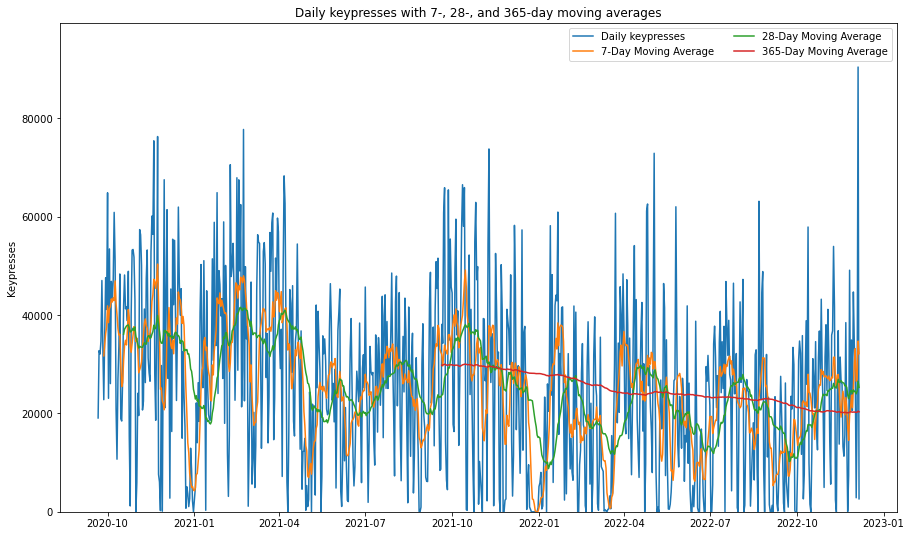

In [34]:
fig, ax = plt.subplots(figsize=[15,9])
fig.set_facecolor('white')
ax.set_ylim(0, max(df_combined_daily_keypresses['keypresses'])*1.1) # This 
# gives the y axis a bit more space to fit in the legend. Using a multiple is
# more flexible than is adding a specific number of keystrokes to the axis.)

ax.plot(df_combined_daily_keypresses['Date'], df_combined_daily_keypresses['keypresses'],label='Daily keypresses')
ax.plot(df_combined_daily_keypresses['Date'], df_combined_daily_keypresses['7_day_ma'],label='7-Day Moving Average')
ax.plot(df_combined_daily_keypresses['Date'], df_combined_daily_keypresses['28_day_ma'],label='28-Day Moving Average')
ax.plot(df_combined_daily_keypresses['Date'], df_combined_daily_keypresses['365_day_ma'],label='365-Day Moving Average')
plt.ylabel('Keypresses')
plt.legend(ncol = 2)
plt.title('Daily keypresses with 7-, 28-, and 365-day moving averages')
plt.savefig('graphs\\daily_keypresses_and_MAs.png', dpi=400)

A similar chart can be made using Plotly. The advantage of this chart is that, being HTML-based, it is interactive in nature. Thus, you can hover over the lines to view the values corresponding to those lines and zoom in to get a closer look at a particular section of the graph.

In [35]:
px_keypresses_line_chart = px.line(df_combined_daily_keypresses, x = 'Date', y = ['keypresses', '7_day_ma', '28_day_ma', '365_day_ma']) # Note that multiple y values can be passed to the line chart. 

px_keypresses_line_chart.write_html('graphs\\px_daily_keypresses_and_mas.html')

px_keypresses_line_chart 

Note that the above output will likely not show if you are viewing this notebook on GitHub. You'll instead need to download it to view the HTML output. (You can open it on your computer using a web browser.)

Plotly graphs can also be saved as static images:

In [36]:
image_width = 2600 # Larger widths will produce more detailed graphs but 
# smaller legends, so you may need to tweak this setting until you find a value
# that works for your own graph.
image_height = image_width * 9/16 # Preserves an HD/UHD aspect ratio

px_keypresses_line_chart.write_image('graphs\\px_daily_keypresses_and_mas_static.png', width = image_width, height = image_height, engine = 'kaleido')
# See https://plotly.com/python/static-image-export/

Here's a copy of this image:

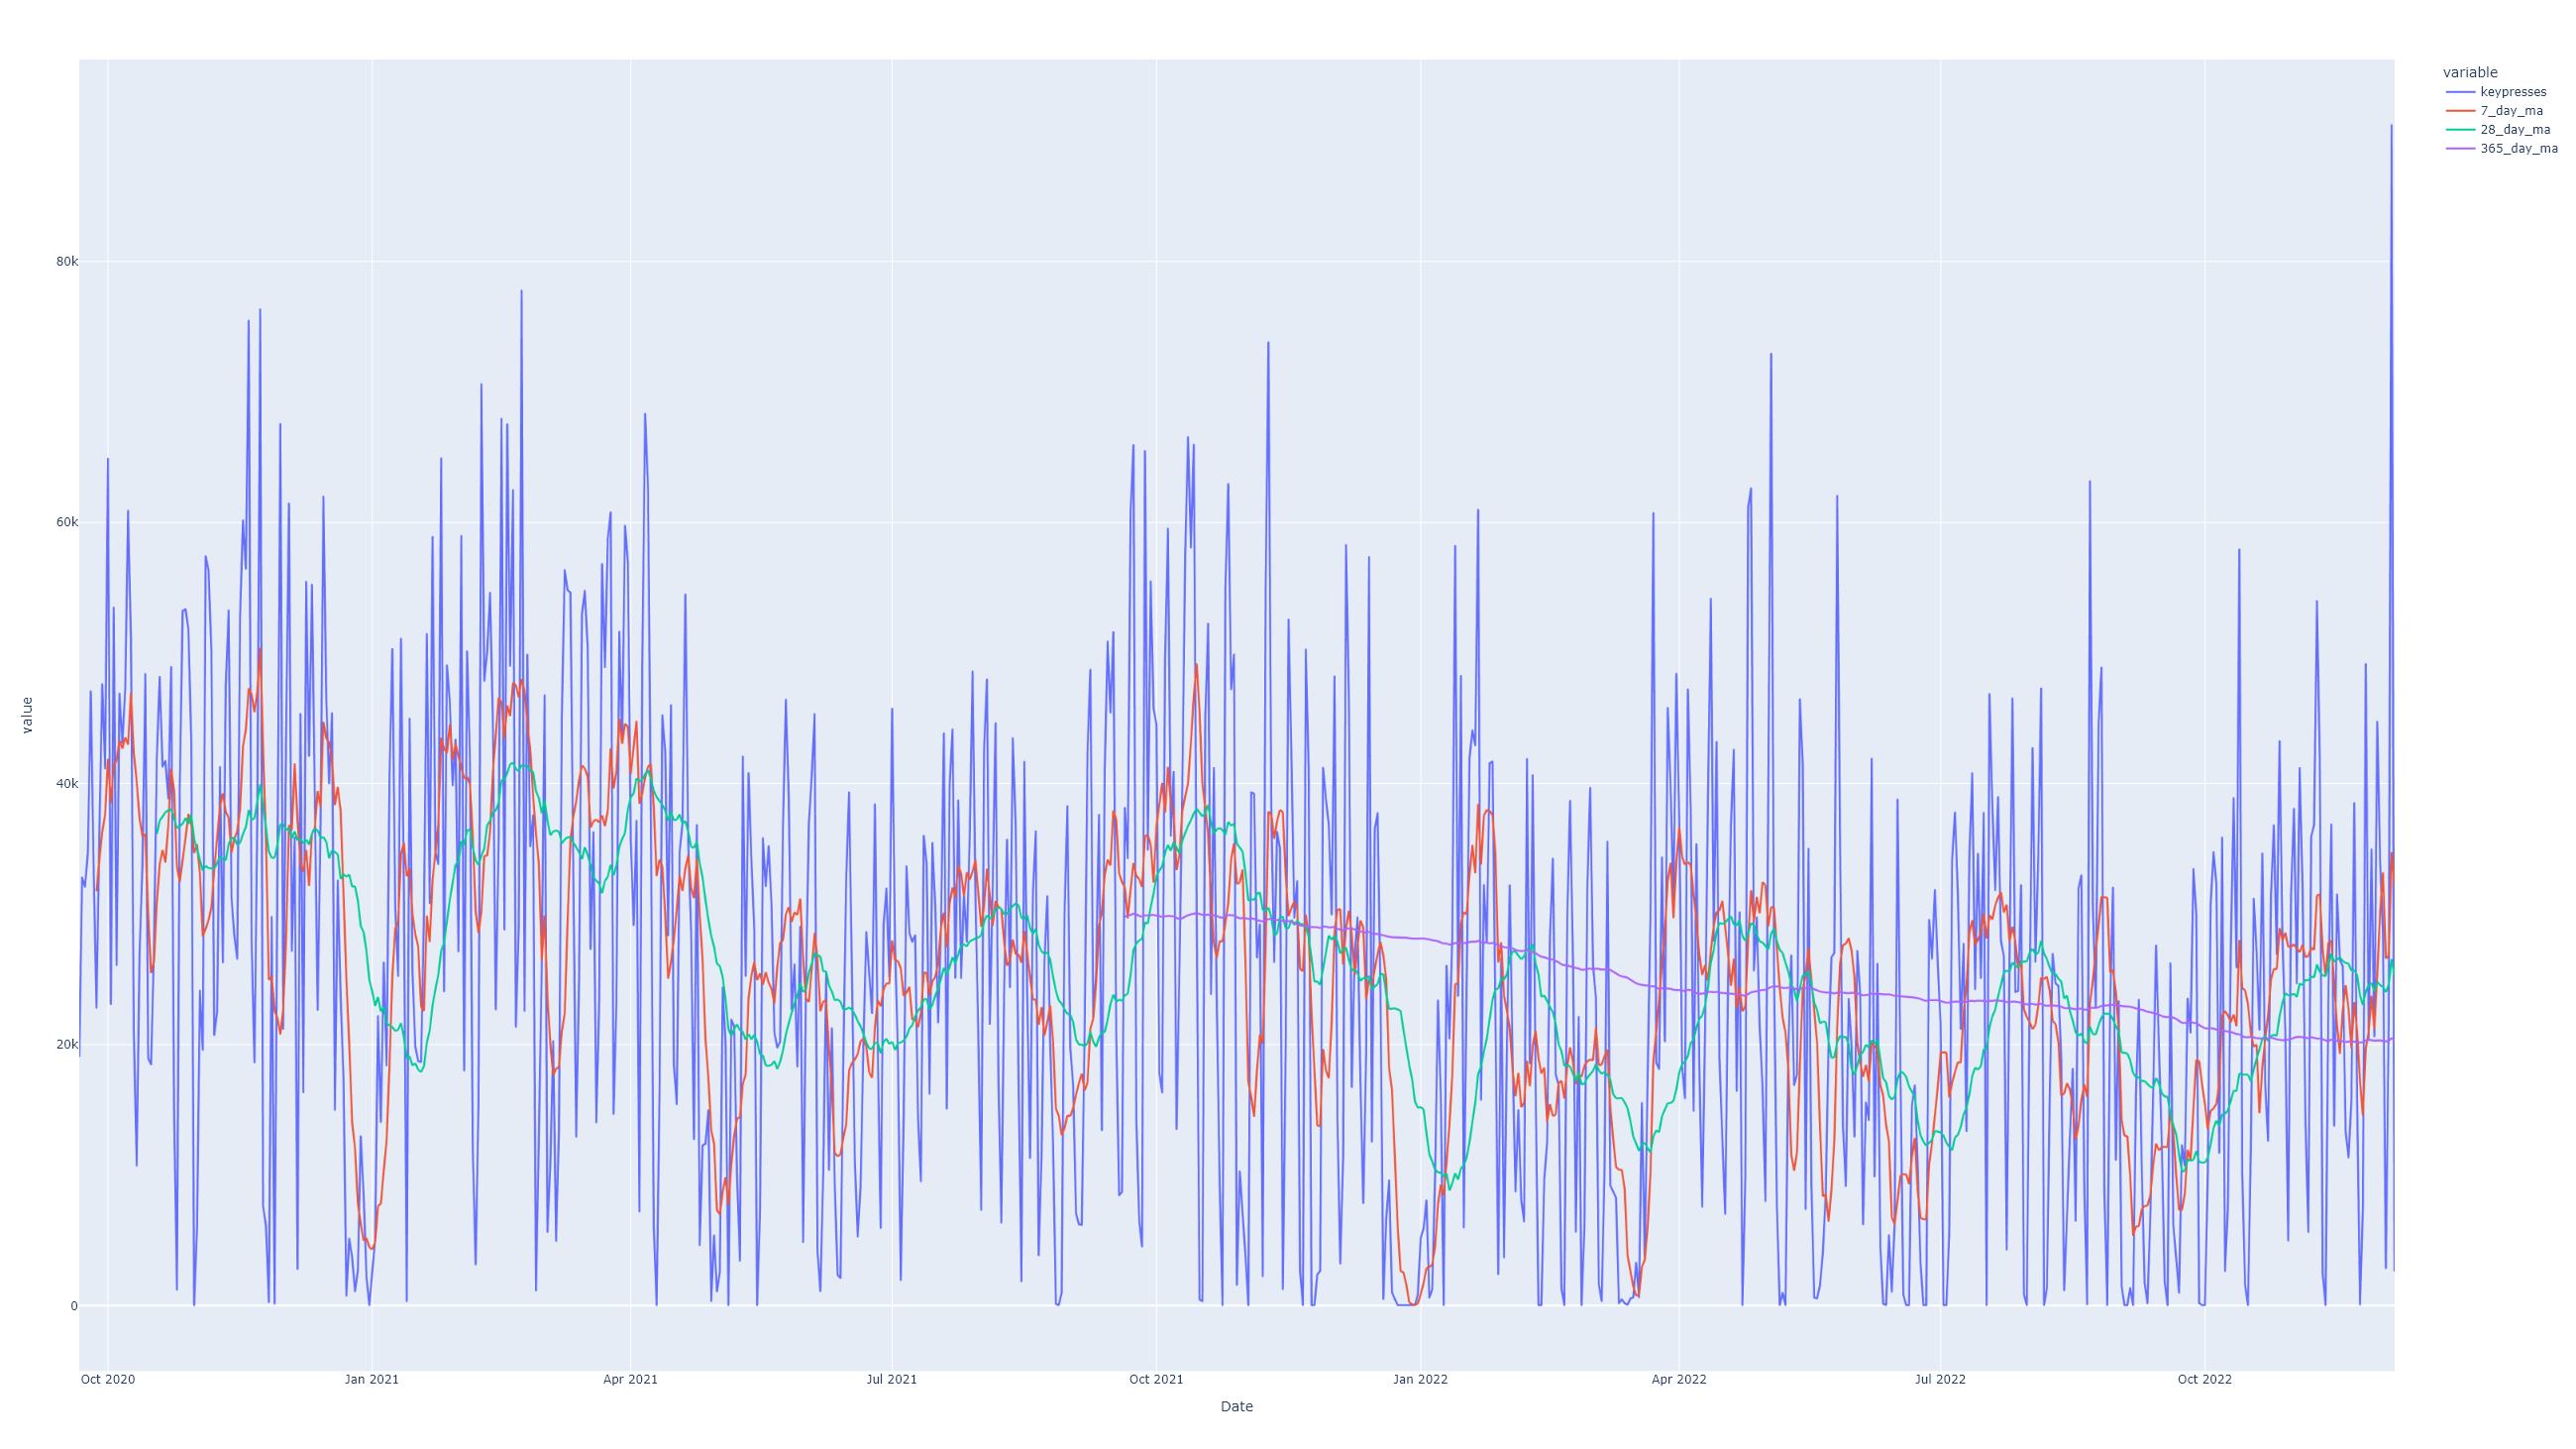

In [37]:
Image('graphs\\px_daily_keypresses_and_mas_static.png')

In [38]:
test_df = df_combined_daily_keypresses.copy()

In [39]:
df_monthly_keypresses = test_df.set_index('Date').resample('M').sum()['keypresses'].reset_index()
df_monthly_keypresses['Month'] = df_monthly_keypresses['Date'].dt.to_period('M')
df_monthly_keypresses['Year'] = df_monthly_keypresses['Date'].dt.to_period('Y')
df_monthly_keypresses.drop('Date', axis = 1, inplace = True)
df_monthly_keypresses['keypresses'] = df_monthly_keypresses.pop('keypresses')
df_monthly_keypresses

,Month,Year,keypresses
0,2020-09,2020,346918
1,2020-10,2020,1140421
2,2020-11,2020,1061614
3,2020-12,2020,823763
4,2021-01,2021,980116
5,2021-02,2021,1088404
6,2021-03,2021,1142850
7,2021-04,2021,833464
8,2021-05,2021,700155
9,2021-06,2021,621894


The following code shows my monthly keypresses from October to April during my 2-year MBA program.

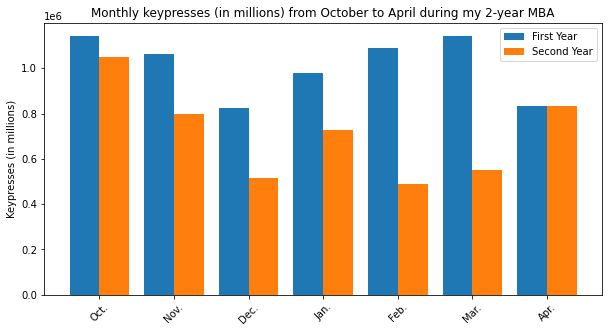

In [40]:
fig, axes = plt.subplots(figsize=[10, 5])
fig.set_facecolor('white')
# Much of the following code was based on:
# https://matplotlib.org/3.5.0/gallery/lines_bars_and_markers/barchart.html
df_first_year = df_monthly_keypresses.query("Month >= '2020-10' & Month <= '2021-04'").copy()
df_second_year = df_monthly_keypresses.query("Month >= '2021-10' & Month <= '2022-04'").copy()
width = 0.4
x = np.arange(len(df_first_year))
axes.bar(x = x - width/2, height = df_first_year['keypresses'], label = 'First Year', width = width)
axes.bar(x = x + width/2, height = df_second_year['keypresses'], label = 'Second Year', width = width)
axes.set_xticks(x, ['Oct.', 'Nov.', 'Dec.', 'Jan.', 'Feb.', 'Mar.', 'Apr.'], rotation = 45)
plt.legend()
plt.ylabel('Keypresses (in millions)')
plt.title('Monthly keypresses (in millions) from October to April during my 2-year MBA')
plt.savefig('graphs\\monthly_keypresses_during_MBA.png', dpi=400)

List of tables in each WhatPulse database file:

In [41]:
# output = sqlalchemy_connection.execute("SELECT name FROM sqlite_schema WHERE type='table' ORDER BY name;") # From https://www.sqlite.org/faq.html#q7 
# print(output.all())
# Tables: [('application_active_hour',), ('application_bandwidth',), ('application_ignore',), ('application_uptime',), ('applications',), ('applications_upgrades',), ('computer_info',), ('country_bandwidth',), ('fact',), ('geekwindow_labels',), ('input_per_application',), ('keycombo_frequency',), ('keycombo_frequency_application',), ('keypress_frequency',), ('keypress_frequency_application',), ('keypresses',), ('last_update_time',), ('milestones',), ('milestones_log',), ('mouseclicks',), ('mouseclicks_frequency',), ('mouseclicks_frequency_application',), ('mousepoints',), ('network_interface_bandwidth',), ('network_interfaces',), ('network_interfaces_ignore',), ('network_protocol_bandwidth',), ('pending_applications_stats',), ('settings',), ('sqlite_sequence',), ('unpulsed_stats',), ('uptimes',)]

In [42]:
df_combined_daily_keypresses.to_csv('whatpulse_daily_keypresses.csv')

## Hourly keypress stats:

In [43]:
hourly_keypress_db_list = []

for db_path in database_paths_list:
    hourly_keypress_db_list.append(generate_hourly_keypress_totals(database_path = db_path))

df_hourly_keypresses = pd.concat([df for df in hourly_keypress_db_list]).reset_index(drop=True)
df_hourly_keypresses

,day,hour,count
0,2021-06-21,13,1209
1,2021-06-21,14,2080
2,2021-06-21,15,971
3,2021-06-21,16,1437
4,2021-06-21,17,612
...,...,...,...
9593,2021-07-03,0,111
9594,2021-07-03,1,119
9595,2021-07-09,16,26
9596,2021-07-09,17,0


Most keypresses typed in a single hour:

In [44]:
df_hourly_keypresses.sort_values('count', ascending = False)

,day,hour,count
5864,2022-12-05,22,17552
1187,2021-09-16,10,15446
6915,2020-12-11,14,14618
3350,2022-03-28,18,13406
1599,2021-10-19,10,13345
...,...,...,...
1244,2021-09-21,1,0
1245,2021-09-21,2,0
1246,2021-09-21,3,0
1247,2021-09-21,4,0


Keypresses by hour:

In [45]:
df_hourly_pivot = df_hourly_keypresses.pivot_table(index = 'hour', values = 'count', aggfunc = 'sum').reset_index()
total_keypresses = df_hourly_pivot['count'].sum()
df_hourly_pivot['pct_of_total'] = 100* df_hourly_pivot['count'] / total_keypresses
df_hourly_pivot

,hour,count,pct_of_total
0,0,899554,4.346530
1,1,487609,2.356065
2,2,186711,0.902164
3,3,60722,0.293401
4,4,13513,0.065293
5,5,1632,0.007886
6,6,311,0.001503
7,7,2575,0.012442
8,8,143180,0.691828
9,9,520638,2.515656


In [46]:
sum(df_hourly_pivot['pct_of_total']) # Making sure the percentages were calculated correctly (they should add up to 100%)

100.0

Using Plotly to create both interactive (.html) and static (.png) hourly keypress charts:

In [47]:
px_keypresses_by_hour = px.bar(df_hourly_pivot, x = 'hour', y = 'pct_of_total')
px_keypresses_by_hour.write_html(r'graphs\px_keypresses_by_hour.html')
px_keypresses_by_hour

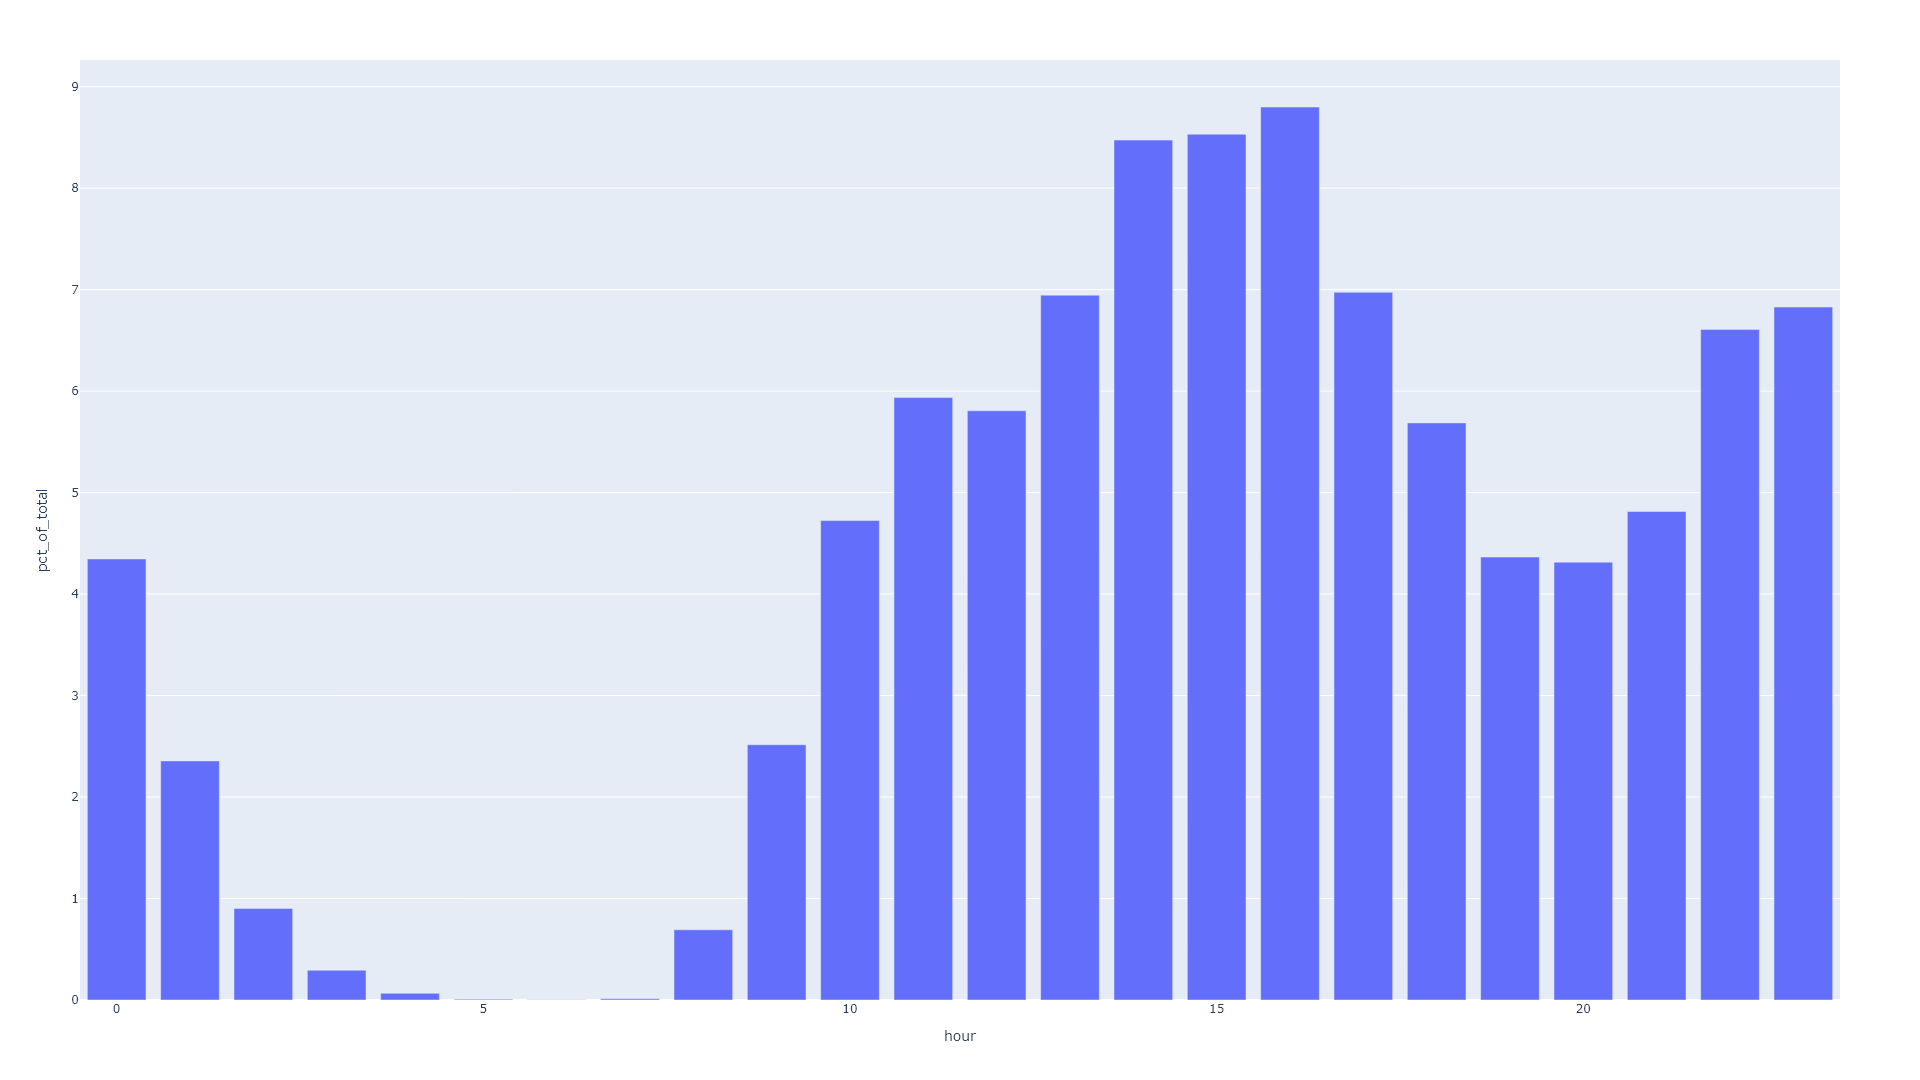

In [48]:
image_width = 1920
image_height = image_width * 9/16
px_keypresses_by_hour.write_image(r'graphs\px_keypresses_by_hour_static.png', width = image_width, height = image_height, engine = 'kaleido')
Image(r'graphs\px_keypresses_by_hour_static.png')

In [49]:
end_time = time.time()
run_time = end_time - start_time
run_minutes = run_time // 60
run_seconds = run_time % 60
print("Completed run at",time.ctime(end_time),"(local time)")
print("Total run time:",'{:.2f}'.format(run_time),"second(s) ("+str(run_minutes),"minute(s) and",'{:.2f}'.format(run_seconds),"second(s))") # Only meaningful when the program is run nonstop from start to finish


Completed run at Tue Dec  6 00:30:50 2022 (local time)
Total run time: 12.18 second(s) (0.0 minute(s) and 12.18 second(s))
